## Agenda
- feature engineering
    - 1) delete id_column
    - 2) CountVectorizer: text+keyword+location
- model
    - bernoullibayes

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("data/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.shape

(7613, 5)

In [4]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
X = train.iloc[:,1:4]
y = train['target']

In [6]:
def combine_features(df):
    df['new_text'] = df.keyword.str.cat([df.location,df.text], sep=' ', na_rep='na')
    df.drop(columns = ['keyword','location','text'],inplace=True)
    return df

In [7]:
X = combine_features(X)
X

,new_text
0,na na Our Deeds are the Reason of this #earthq...
1,na na Forest fire near La Ronge Sask. Canada
2,na na All residents asked to 'shelter in place...
3,"na na 13,000 people receive #wildfires evacuat..."
4,na na Just got sent this photo from Ruby #Alas...
...,...
7608,na na Two giant cranes holding a bridge collap...
7609,na na @aria_ahrary @TheTawniest The out of con...
7610,na na M1.94 [01:04 UTC]?5km S of Volcano Hawai...
7611,na na Police investigating after an e-bike col...


In [8]:
y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [9]:
X = X.new_text
y = train['target']

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vect1 = CountVectorizer()
#vect2 = CountVectorizer()
#vect.fit_transform(X)

In [11]:
from sklearn.naive_bayes import BernoulliNB
#nb = MultinomialNB()
bnb = BernoulliNB() #0.740187

from sklearn.linear_model import LogisticRegression,SGDClassifier,RidgeClassifier
lg = LogisticRegression(random_state=318) 
sgd = SGDClassifier(random_state=318)
rc = RidgeClassifier(random_state=318)

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=318)

from sklearn.svm import SVC
svc = SVC(probability=True) #0.69527

from sklearn.ensemble import VotingClassifier,RandomForestClassifier
rfc = RandomForestClassifier() #0.69500

#vc = VotingClassifier([('svc',svc),('rfc',rfc),('bnb',bnb)])

In [12]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(vect1, bnb)

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.7401874714733265

In [14]:
pipe.steps

[('countvectorizer', CountVectorizer()), ('bernoullinb', BernoulliNB())]

In [15]:
pipe.fit(X,y)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('bernoullinb', BernoulliNB())])

In [16]:
from sklearn.model_selection import GridSearchCV

params = {}
params['bernoullinb__alpha'] = [0.1,0.5,1,2]
params['bernoullinb__fit_prior'] = [True, False]

In [17]:
grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy')
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('bernoullinb', BernoulliNB())]),
             param_grid={'bernoullinb__alpha': [0.1, 0.5, 1, 2],
                         'bernoullinb__fit_prior': [True, False]},
             scoring='accuracy')

In [18]:
grid.best_score_

0.7401874714733265

In [19]:
grid.best_params_

{'bernoullinb__alpha': 1, 'bernoullinb__fit_prior': True}

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


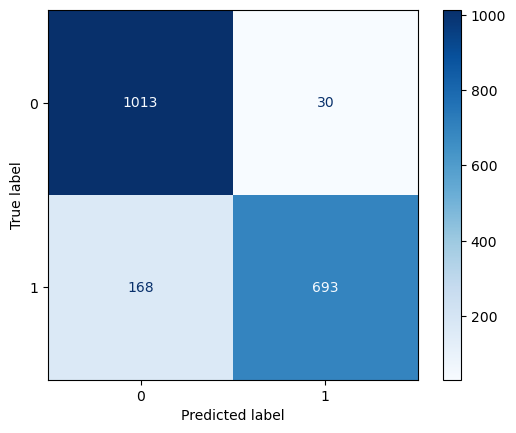

In [20]:
#draw a diffusion matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=318)
disp = plot_confusion_matrix(grid, X_test, y_test, cmap='Blues', values_format='d')

In [21]:
#null_accuracy
print(train.target.value_counts().max()/train.target.value_counts().sum())

0.5703402075397347


In [22]:
#read test data
test = pd.read_csv('data/test.csv')

In [23]:
test = combine_features(test)

In [24]:
X_test = test.new_text

In [25]:
result = grid.predict(X_test)

In [26]:
result

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [27]:
pd.DataFrame({'id':test.id, 'target':result}).set_index('id').to_csv('submission.csv')

- 0.79436

In [28]:
# #create preprocessor
# from sklearn.impute import SimpleImputer
# from sklearn.compose import make_column_transformer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.pipeline import make_pipeline
# from sklearn.feature_extraction.text import CountVectorizer

# imp_unknown = SimpleImputer(strategy='constant')
# ohe = OneHotEncoder(handle_unknown='ignore')
# #vect = CountVectorizer(token_pattern=r"'([a-z ]+)'")
# vect = CountVectorizer()

# preprocessor = make_column_transformer(#报错？
#     (make_pipeline(imp_unknown, ohe), ['keyword','location'])
# )

In [29]:
# create the feature matrix from the DataFrame
# X_train = preprocessor.fit_transform(X)
# X_dtm_manual.shape